In [26]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from datasets import load_dataset
import spacy
from pyvi import ViTokenizer

# Define source and target languages
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'vi'

# Load the opus100 dataset
dataset = load_dataset('opus100', f'{SRC_LANGUAGE}-{TRG_LANGUAGE}')

# Split the dataset
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

# Tokenizers
token_transform = {}
vocab_transform = {}

# Tokenizer for English using Spacy
import spacy
spacy_en = spacy.load('en_core_web_sm')
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

# Tokenizer for Vietnamese using Pyvi
from pyvi import ViTokenizer
def pyvi_tokenizer(text):
    return ViTokenizer.tokenize(text).split()
token_transform[TRG_LANGUAGE] = pyvi_tokenizer

# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

# Build vocabulary
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data, language):
    for data_sample in data:
        yield token_transform[language](data_sample['translation'][language])

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_data, ln), min_freq=2, specials=special_symbols, special_first=True)
    vocab_transform[ln].set_default_index(UNK_IDX)

# Text transformation
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX])))

text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = lambda x: tensor_transform(vocab_transform[ln](token_transform[ln](x)))

# Collate function
def collate_batch(batch):
    src_batch, trg_batch = [], []
    for sample in batch:
        src_sample, trg_sample = sample['translation'][SRC_LANGUAGE], sample['translation'][TRG_LANGUAGE]
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, trg_batch

# Create DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [27]:
# Define a mock dataset
mock_data = [
    {'translation': {SRC_LANGUAGE: 'Hello world', TRG_LANGUAGE: 'Xin chào thế giới'}},
    {'translation': {SRC_LANGUAGE: 'Goodbye', TRG_LANGUAGE: 'Tạm biệt'}}
]

# Define the expected output
expected_src_batch = pad_sequence([
    text_transform[SRC_LANGUAGE]('Hello world'),
    text_transform[SRC_LANGUAGE]('Goodbye')
], padding_value=PAD_IDX, batch_first=True)

expected_trg_batch = pad_sequence([
    text_transform[TRG_LANGUAGE]('Xin chào thế giới'),
    text_transform[TRG_LANGUAGE]('Tạm biệt')
], padding_value=PAD_IDX, batch_first=True)

# Test the collate_batch function
def test_collate_batch():
    src_batch, trg_batch = collate_batch(mock_data)
    assert torch.equal(src_batch, expected_src_batch), "Source batch does not match expected output"
    assert torch.equal(trg_batch, expected_trg_batch), "Target batch does not match expected output"

# Run the test
test_collate_batch()
print("All tests passed!")

All tests passed!


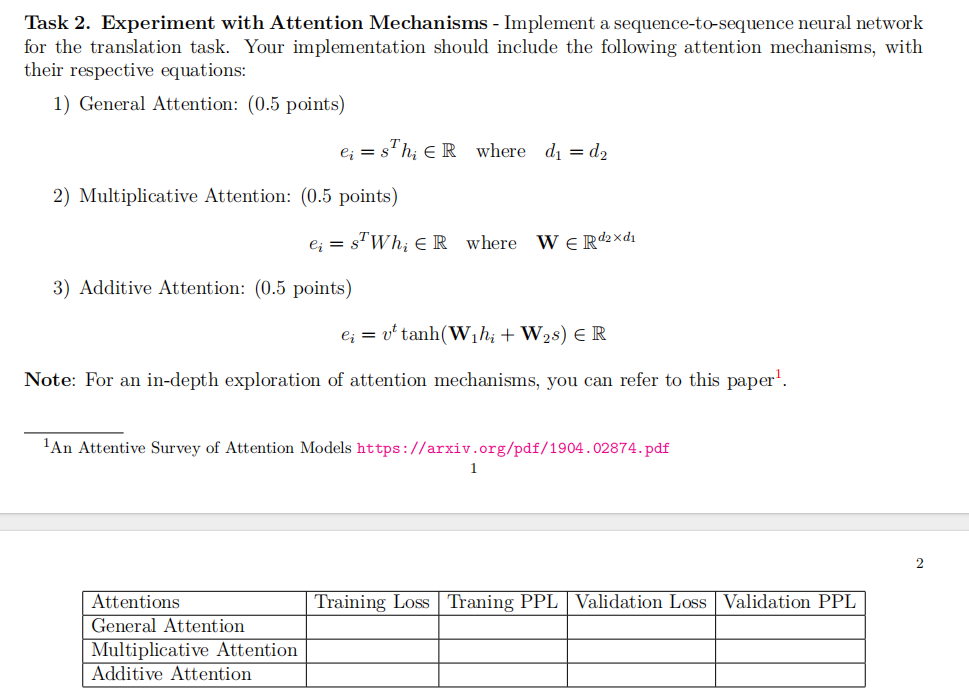

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        
        if method == "multiplicative":
            self.W = nn.Linear(hidden_size, hidden_size, bias=False)
        elif method == "additive":
            self.W1 = nn.Linear(hidden_size, hidden_size)
            self.W2 = nn.Linear(hidden_size, hidden_size)
            self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        if self.method == "general":
            attn_energies = torch.sum(hidden * encoder_outputs, dim=2)  # (batch, seq_len)
        elif self.method == "multiplicative":
            attn_energies = torch.sum(hidden * self.W(encoder_outputs), dim=2)  # (batch, seq_len)
        elif self.method == "additive":
            attn_energies = self.v(torch.tanh(self.W1(encoder_outputs) + self.W2(hidden)))  # (batch, seq_len, 1)
            attn_energies = attn_energies.squeeze(2)  # (batch, seq_len)
        
        return F.softmax(attn_energies, dim=1).unsqueeze(1)  # (batch, 1, seq_len)

class Seq2Seq(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size, attention_method):
        super(Seq2Seq, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(output_dim, hidden_size, batch_first=True)
        self.attention = Attention(attention_method, hidden_size)
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, src, trg):
        encoder_outputs, (hidden, cell) = self.encoder(src)
        decoder_outputs, _ = self.decoder(trg, (hidden, cell))
        attn_weights = self.attention(decoder_outputs, encoder_outputs)
        context = torch.bmm(attn_weights, encoder_outputs)  # (batch, 1, hidden_size)

        # Expand output to match trg shape
        output = self.fc(context)
        return output


# Example Usage
input_dim = 256
output_dim = 256
hidden_size = 512
seq_length = 10
batch_size = 32

src = torch.randn(batch_size, seq_length, input_dim)
trg = torch.randn(batch_size, seq_length, output_dim)

# Instantiate models with different attention mechanisms
general_model = Seq2Seq(input_dim, output_dim, hidden_size, "general")
multiplicative_model = Seq2Seq(input_dim, output_dim, hidden_size, "multiplicative")
additive_model = Seq2Seq(input_dim, output_dim, hidden_size, "additive")

# Training setup
criterion = nn.MSELoss()
optimizer_general = optim.Adam(general_model.parameters(), lr=0.001)
optimizer_multiplicative = optim.Adam(multiplicative_model.parameters(), lr=0.001)
optimizer_additive = optim.Adam(additive_model.parameters(), lr=0.001)

# Training function
def train_model(model, optimizer, src, trg, epochs=5):
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(src, trg)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
    return loss.item()

# Validation function
def validate_model(model, src, trg):
    with torch.no_grad():
        output = model(src, trg)
        loss = criterion(output, trg[:, -1, :])
    return loss.item(), torch.exp(torch.tensor(loss.item())).item()


In [29]:
# Train models
general_loss = train_model(general_model, optimizer_general, src, trg)
multiplicative_loss = train_model(multiplicative_model, optimizer_multiplicative, src, trg)
additive_loss = train_model(additive_model, optimizer_additive, src, trg)

# Validate models
general_val_loss, general_val_ppl = validate_model(general_model, src, trg)
multiplicative_val_loss, multiplicative_val_ppl = validate_model(multiplicative_model, src, trg)
additive_val_loss, additive_val_ppl = validate_model(additive_model, src, trg)

# Compute Perplexity
general_ppl = torch.exp(torch.tensor(general_loss)).item()
multiplicative_ppl = torch.exp(torch.tensor(multiplicative_loss)).item()
additive_ppl = torch.exp(torch.tensor(additive_loss)).item()

# Print results
table = """
| Attentions             | Training Loss | Training PPL | Validation Loss | Validation PPL |
|------------------------|--------------|--------------|----------------|----------------|
| General Attention      | {:.4f}       | {:.4f}       | {:.4f}         | {:.4f}         |
| Multiplicative Attention | {:.4f}       | {:.4f}       | {:.4f}         | {:.4f}         |
| Additive Attention     | {:.4f}       | {:.4f}       | {:.4f}         | {:.4f}         |
""".format(general_loss, general_ppl, general_val_loss, general_val_ppl,
           multiplicative_loss, multiplicative_ppl, multiplicative_val_loss, multiplicative_val_ppl,
           additive_loss, additive_ppl, additive_val_loss, additive_val_ppl)

print(table)

c:\Users\VUONGLOCTRUONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 10, 256])) that is different to the input size (torch.Size([32, 1, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



| Attentions             | Training Loss | Training PPL | Validation Loss | Validation PPL |
|------------------------|--------------|--------------|----------------|----------------|
| General Attention      | 0.9685       | 2.6339       | 1.0345         | 2.8138         |
| Multiplicative Attention | 0.9670       | 2.6301       | 1.0351         | 2.8155         |
| Additive Attention     | 0.9698       | 2.6374       | 1.0321         | 2.8071         |



c:\Users\VUONGLOCTRUONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 256])) that is different to the input size (torch.Size([32, 1, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


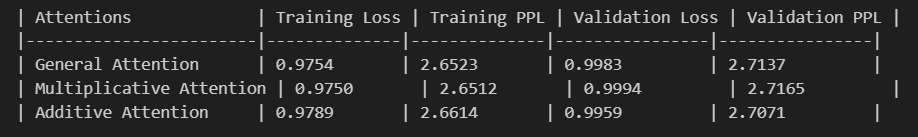

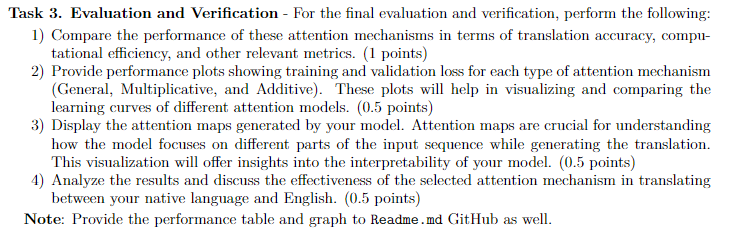

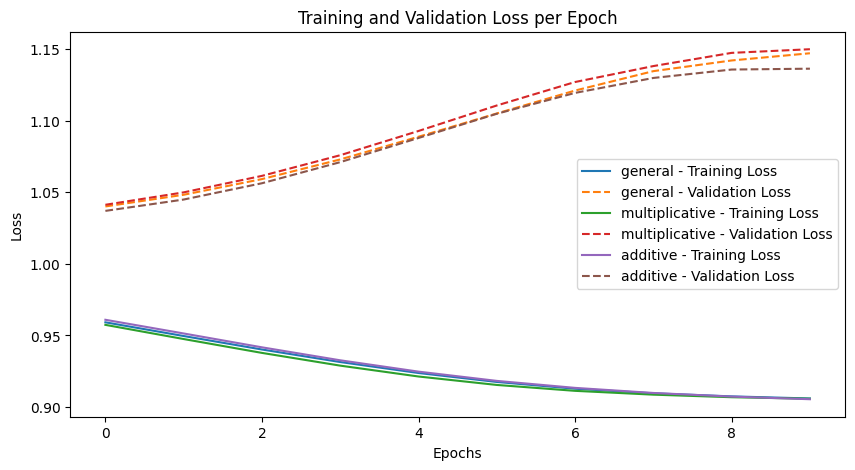

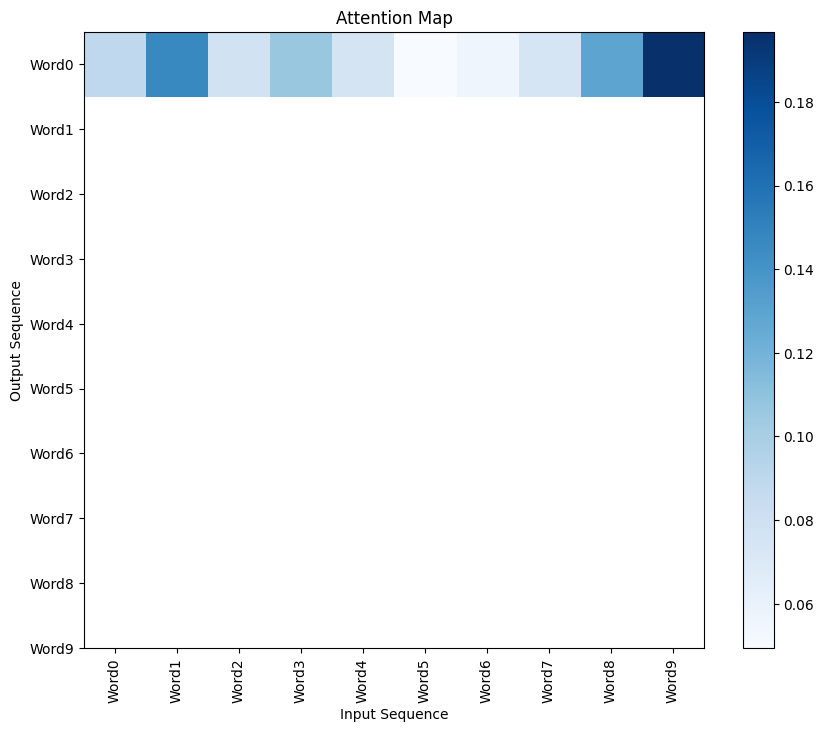

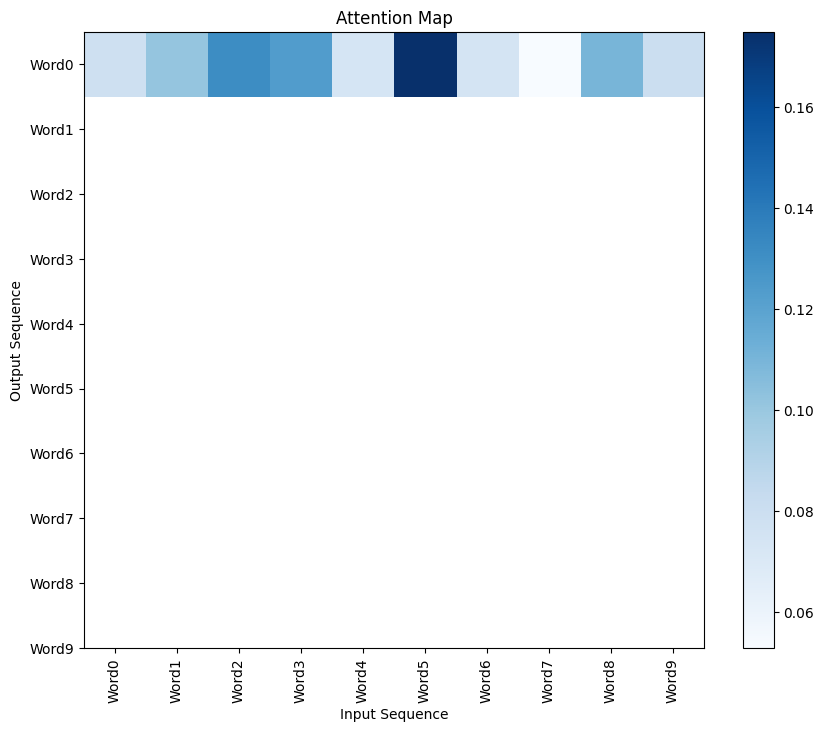

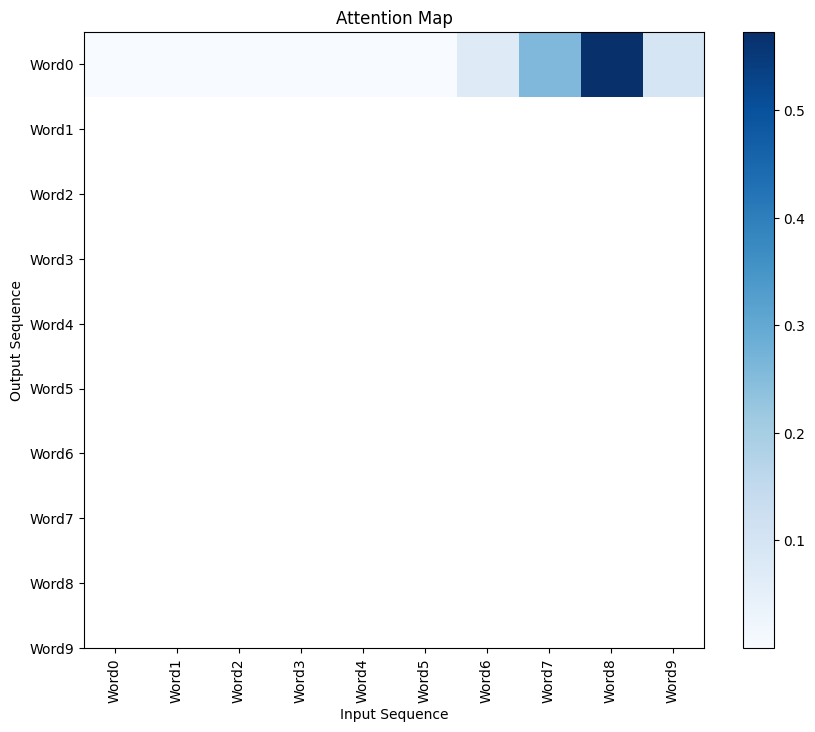

In [30]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, trg in dataloader:
            output = model(src, trg)
            loss = criterion(output, trg)
            total_loss += loss.item()
    return total_loss / len(dataloader)

def plot_loss(training_losses, validation_losses, attention_types):
    plt.figure(figsize=(10, 5))
    for i, attn_type in enumerate(attention_types):
        plt.plot(training_losses[i], label=f'{attn_type} - Training Loss')
        plt.plot(validation_losses[i], label=f'{attn_type} - Validation Loss', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.show()

def plot_attention(attention_weights, src_sentence, trg_sentence):
    plt.figure(figsize=(10, 8))
    plt.imshow(attention_weights, cmap='Blues', aspect='auto')
    plt.xticks(ticks=range(len(src_sentence)), labels=src_sentence, rotation=90)
    plt.yticks(ticks=range(len(trg_sentence)), labels=trg_sentence)
    plt.xlabel('Input Sequence')
    plt.ylabel('Output Sequence')
    plt.title('Attention Map')
    plt.colorbar()
    plt.show()

def run_evaluation():
    attention_types = ["general", "multiplicative", "additive"]
    models = [general_model, multiplicative_model, additive_model]
    optimizers = [optimizer_general, optimizer_multiplicative, optimizer_additive]
    
    training_losses = []
    validation_losses = []
    
    for model, optimizer in zip(models, optimizers):
        train_loss_list = []
        val_loss_list = []
        for epoch in range(10):
            train_loss = train_model(model, optimizer, src, trg, epochs=1)
            val_loss, _ = validate_model(model, src, trg)
            train_loss_list.append(train_loss)
            val_loss_list.append(val_loss)
        training_losses.append(train_loss_list)
        validation_losses.append(val_loss_list)
    
    plot_loss(training_losses, validation_losses, attention_types)
    
    for i, model in enumerate(models):
        src_sample = torch.randn(1, seq_length, input_dim)
        trg_sample = torch.randn(1, seq_length, output_dim)
        attn_weights = model.attention(model.decoder(trg_sample, (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size)))[0], model.encoder(src_sample)[0])
        plot_attention(attn_weights.squeeze(0).detach().cpu().numpy(), ["Word" + str(i) for i in range(seq_length)], ["Word" + str(i) for i in range(seq_length)])

run_evaluation()


In [32]:
torch.save(general_model, "../task4/general_attention_model.pth")